## Import Packages and Libraries

In [142]:
# import packages and libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile as shp
import re
import json
import requests
import warnings
import geopandas as gpd
import scipy.stats as stats
import string
from pygeocoder import Geocoder
from collections import defaultdict
from collections import OrderedDict
from IPython.display import HTML
from shapely.geometry import Point
from sklearn.cluster import Birch
from sklearn.exceptions import DataConversionWarning
import gmaps
import gmaps.datasets
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Configure google maps API

In [143]:
gmaps.configure(api_key="")

## Specify formatting and ignore warnings

In [144]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

In [145]:
# Specify Formatting
display(HTML(r"<style>.output {display: flex; \
              align-items: center; \
              text-align: center;} \
              </style>"))

In [146]:
# Ignore warnings
warnings.simplefilter(action="ignore", \
                      category=FutureWarning)

warnings.filterwarnings(action='ignore', \
                        category=DataConversionWarning)

In [147]:
# Define function to remove white space
def remove_whitespace(x):
    table = {ord(char): None for char in string.whitespace}
    return x.translate(table)

## Load Raw Data

In [148]:
# load csv files as pandas dataframes removing rows with invalid data
alt_df = pd.read_csv('alt_fuel_stations (Jun 18 2019).csv',parse_dates = True, error_bad_lines=False,low_memory=False)
# https://afdc.energy.gov/data/10581
veh_sales_df = pd.read_csv('Alternative_Fuels_Sales.csv', parse_dates=True, error_bad_lines=False)

## Perform Data Wrangling

## Alternative Fuels Stations Data

In [149]:
# Call function to clean white space from column names
alt_df.rename(columns=remove_whitespace, inplace=True)

In [150]:
# View updated column names
alt_df.columns

Index(['FuelTypeCode', 'StationName', 'StreetAddress',
       'IntersectionDirections', 'City', 'State', 'ZIP', 'Plus4',
       'StationPhone', 'StatusCode', 'ExpectedDate', 'GroupsWithAccessCode',
       'AccessDaysTime', 'CardsAccepted', 'BDBlends', 'NGFillTypeCode',
       'NGPSI', 'EVLevel1EVSENum', 'EVLevel2EVSENum', 'EVDCFastCount',
       'EVOtherInfo', 'EVNetwork', 'EVNetworkWeb', 'GeocodeStatus', 'Latitude',
       'Longitude', 'DateLastConfirmed', 'ID', 'UpdatedAt', 'OwnerTypeCode',
       'FederalAgencyID', 'FederalAgencyName', 'OpenDate',
       'HydrogenStatusLink', 'NGVehicleClass', 'LPGPrimary', 'E85BlenderPump',
       'EVConnectorTypes', 'Country', 'IntersectionDirections(French)',
       'AccessDaysTime(French)', 'BDBlends(French)',
       'GroupsWithAccessCode(French)', 'HydrogenIsRetail', 'AccessCode',
       'AccessDetailCode', 'FederalAgencyCode', 'FacilityType',
       'CNGDispenserNum', 'CNGOn-SiteRenewableSource',
       'CNGTotalCompressionCapacity', 'CNGStora

Clean zipcodes by removing whitespace, converting long zipcodes to short ones and convert them into integer format.

In [151]:
# Clean Zipcodes
alt_df.ZIP = alt_df.ZIP.str.strip()

In [152]:
# Zip is in string format
# Selecting first 5 characters to be the Zip to avoid long postal codes in alt_df
alt_df.ZIP = alt_df.ZIP.str[0:5]

In [153]:
# Convert Zip datatype to be numeric in alt_df
alt_df.ZIP = pd.to_numeric(alt_df.ZIP, errors='coerce')
# Check for any null values
alt_df[alt_df.ZIP.isnull()] 
# Convert Zip to int64
alt_df['ZIP'] = alt_df['ZIP'].fillna(0).astype(numpy.int64)
type(alt_df.ZIP[0])

numpy.int64

Look for invalid zipcodes and drop them from the dataframe.

In [154]:
# Check rows with zipcodes 0
alt_df.ZIP[alt_df.ZIP==0]

20977    0
21119    0
21244    0
29824    0
Name: ZIP, dtype: int64

In [155]:
# Remove 4 rows with invalid zipcode
alt_df = alt_df[alt_df.ZIP!=0]

Drop duplicate rows if any exist and view shape.

In [156]:
# Remove duplicate rows if any
alt_df=alt_df.drop_duplicates()

In [157]:
# View shape
alt_df.shape

(29824, 63)

Create a new dataframe by performing a deep copy from the raw data filtering only rows with a valid open date.
We are going to do an anaylsis of the growth of alternative fuel stations across United States, so it is necessary that we have valid open date for the existing stations.

In [158]:
# Create a new df to hold origingal opendate
open_df=alt_df.copy()

In [159]:
open_df.OpenDate=open_df.OpenDate.fillna(0)
open_df = open_df[open_df.OpenDate!=0]
open_df.shape

(14420, 63)

Convert the date fields to pandas datetime format.

In [160]:
# Convert Open Date from string to pandas datetime
alt_df.OpenDate= pd.to_datetime(alt_df.OpenDate)
open_df.OpenDate=pd.to_datetime(open_df.OpenDate)
alt_df.DateLastConfirmed= pd.to_datetime(alt_df.DateLastConfirmed)

In [161]:
# Fill OpenDate null values to contain DateLastConfirmed
alt_df.OpenDate=alt_df.OpenDate.fillna(alt_df.DateLastConfirmed)

Create a new column for the Year the station was opened by retrieving the year from the open date.    
Convert the OpenYear column to contain numeric values.

In [162]:
# Function to get year from dateAdded
def get_year(dt):
    return dt.year

In [163]:
# Add a new column in the alt_df to include the year it was opened
alt_df['OpenYear'] = alt_df.OpenDate.map(get_year)
open_df['OpenYear']=open_df.OpenDate.map(get_year)

In [164]:
# Convert OpenYear to integer
alt_df.OpenYear = pd.to_numeric(alt_df.OpenYear).fillna(0).astype(int)
open_df.OpenYear = pd.to_numeric(open_df.OpenYear).fillna(0).astype(int)

Select only required fields from the raw data and save as new dataframe containing the station ID, FuelTypeCode, StationName, StreetAddress, IntersectionDirections, City, State, ZIP, GeocodeStatus, Latitude, Longitude, Country, OpenDate and OpenYear.

In [165]:
# Select required columns and create new dataframe alt_fuels_df
alt_fuels_df = alt_df[['ID','FuelTypeCode','StationName', 'StreetAddress',
       'IntersectionDirections', 'City', 'State', 'ZIP','GeocodeStatus', 'Latitude',
       'Longitude','OpenDate','Country','OpenYear']]
open_fuels_df = open_df[['ID','FuelTypeCode','StationName', 'StreetAddress',
       'IntersectionDirections', 'City', 'State', 'ZIP','GeocodeStatus', 'Latitude',
       'Longitude','OpenDate','Country','OpenYear']]

In [166]:
alt_fuels_df.head()

,ID,FuelTypeCode,StationName,StreetAddress,IntersectionDirections,City,State,ZIP,GeocodeStatus,Latitude,Longitude,OpenDate,Country,OpenYear
0,42,CNG,PS Energy - Atlanta,340 Whitehall St,"From I-7585 N, exit 91 to Central Ave, left on...",Atlanta,GA,30303,200-8,33.745843,-84.398837,1994-07-15,US,1994
1,72,CNG,Clean Energy - Texas Department of Transportation,7721A Washington St,"I-10, Washington Ave exit, 1.5 blocks to the s...",Houston,TX,77007,200-9,29.779918,-95.435385,1996-12-15,US,1996
2,73,CNG,Arkansas Oklahoma Gas Corp,2100 S Waldron Rd,NaN,Fort Smith,AR,72903,200-9,35.362213,-94.375338,1997-01-01,US,1997
3,81,CNG,Clean Energy - Logan International Airport,14 Cottage St,"From Route 1, take the first exit after Callah...",Boston,MA,2128,200-9,42.366120,-71.036737,1996-11-15,US,1996
4,83,CNG,Clean Energy - West Roxbury - National Grid,201 Rivermoor St,NaN,West Roxbury,MA,2132,200-9,42.279048,-71.182767,1996-11-15,US,1996


In [167]:
# View shape
alt_fuels_df.shape

(29824, 14)

In [168]:
# View columns
alt_fuels_df.columns

Index(['ID', 'FuelTypeCode', 'StationName', 'StreetAddress',
       'IntersectionDirections', 'City', 'State', 'ZIP', 'GeocodeStatus',
       'Latitude', 'Longitude', 'OpenDate', 'Country', 'OpenYear'],
      dtype='object')

Check for outliers for Latitude and Longitude. 

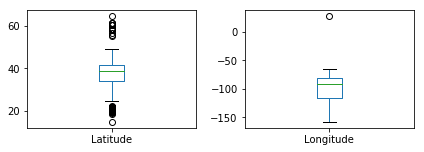

In [169]:
# Create a box plot to check outliers 
fig=plt.figure()
plt.subplot(2,2,1)
alt_fuels_df.Latitude.plot(kind="box")
plt.subplot(2,2,2)
alt_fuels_df.Longitude.plot(kind="box")
plt.tight_layout()

From the boxplots, we can see that there are few outliers with Latitude and Logitude of 0 also. We can drop those rows which will enable accurate mapping plots.

In [171]:
#drop outliers
alt_fuels_df = alt_fuels_df[alt_fuels_df.Longitude<-50]
open_fuels_df = open_fuels_df[open_fuels_df.Longitude<-50]

Save it to new csv files for future use to perform Exploratory Data Analysis and ML. 

In [54]:
# Save it to csv
alt_fuels_df.to_csv('alt_fuels.csv')
open_fuels_df.to_csv('open_fuels.csv')

We saved as two files, alt_fuels.csv containing data with all rows and open_fuels.csv containing only rows with valid OpenDate, Latitude and Longitude.

## Alternative Fuels equipped Vehicle Data

In [172]:
# View Columns
veh_sales_df.columns

Index(['FuelType', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

In [173]:
# View data frame
veh_sales_df.head()

,FuelType,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,E85,47643,72899,221834,385671,524169,642520,403981,479706,197187,259337,275508,271996,457817,327865
1,ELEC,10674,18553,43886,81987,101954,107585,30613,50503,141406,83339,82834,94330,129827,178011
2,BD,31922,52275,91584,98785,17222,2814,88726,99347,103106,98028,130540,189823,160763,150695
3,CNG,76257,49271,57458,55021,51121,44317,42911,48157,59521,79616,68479,107283,98388,97271
4,LPG,31338,21117,25543,23628,22260,7937,13196,18793,16501,35554,17404,22762,23648,34753


The dataframe contains Year as the column header. We want Fuel Type to be the column header.      
We transpose the dataframe and make first row as the column header to contain Fuel Types as the column names.

In [174]:
# Transpose rows and columns
veh_sales_df = veh_sales_df.T

In [175]:
# View data frame
veh_sales_df.head()

,0,1,2,3,4,5,6,7,8
FuelType,E85,ELEC,BD,CNG,LPG,LNG,HY,PEVs,Total
2004,47643,10674,31922,76257,31338,0,23,9241,207098
2005,72899,18553,52275,49271,21117,1873,42,7464,223494
2006,221834,43886,91584,57458,25543,2271,72,9481,452129
2007,385671,81987,98785,55021,23628,1731,86,5895,652804


In [176]:
# Make first row as column header
veh_sales_df=veh_sales_df.rename(columns=veh_sales_df.iloc[0]).drop(veh_sales_df.index[0])

In [177]:
# View data frame
veh_sales_df.head()

,E85,ELEC,BD,CNG,LPG,LNG,HY,PEVs,Total
2004,47643,10674,31922,76257,31338,0,23,9241,207098
2005,72899,18553,52275,49271,21117,1873,42,7464,223494
2006,221834,43886,91584,57458,25543,2271,72,9481,452129
2007,385671,81987,98785,55021,23628,1731,86,5895,652804
2008,524169,101954,17222,51121,22260,2053,75,14135,732989


PEVs are electric vehicles. Let us keep all electric vehicles undert one Fuel Type ELEC.    
Add the number of PEVs to the number of ELEC vehicles and group them as one Fuel Type and drop the PEVs column.

In [178]:
# PEVs are electric vehicles too, so combine with ELEC
veh_sales_df['ELEC']=veh_sales_df.ELEC + veh_sales_df.PEVs

In [179]:
veh_sales_df.drop('PEVs', axis=1, inplace=True) 

Set the index of the dataframe to Year.

In [180]:
veh_sales_df.index.name = 'Year'
veh_sales_df.head()

,E85,ELEC,BD,CNG,LPG,LNG,HY,Total
Year,,,,,,,,
2004,47643,19915,31922,76257,31338,0,23,207098
2005,72899,26017,52275,49271,21117,1873,42,223494
2006,221834,53367,91584,57458,25543,2271,72,452129
2007,385671,87882,98785,55021,23628,1731,86,652804
2008,524169,116089,17222,51121,22260,2053,75,732989


Save it to new csv file for future use to perform Exploratory Data Analysis and ML. 

In [65]:
veh_sales_df.to_csv('veh_sales.csv')